In [1]:
from pathlib import Path

# Automatically get the base path of your project
base_path = Path.cwd().parents[0]  # adjust .parents[0] if needed
print("Base path of the project:", base_path)

Base path of the project: c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db


## Step 1: Define the Query Database and Label

In this step, we specify which protein database we want to compare against the **metagenomics reference database**. This custom query database contains proteins we previously selected, clustered, or filtered using specific strategies (e.g., top-ranked taxa, clustering at 95% identity, etc.).

### Why we do this:
- It defines the **input protein database** for the overlap comparison.
- This helps assess how well your constructed protein database represents the proteomic space found in the metagenomics sample.
- The `query_db_label` ensures all results and logs are clearly labeled, especially when analyzing multiple databases.

### How this fits in the pipeline:
- It sets the stage for all subsequent steps, including DIAMOND alignment and overlap analysis.
- Every result calculated later (e.g., matched proteins, percentages) will be based on this database.


In [2]:
# Paste the file path of the database you want to compare with the metagenomics database between the quotes
query_db = r"C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\pipelines\Diamond_alignments\session_diamond_align_2025-06-08_00-28-56\diamond_proteins_from_proteomes_clustered95_with_metadata.fasta"

# Define a short label for the database; this will be used in print statements and summary reports
query_db_label = "Diamond_lca_proteomes_clustered95"

In [3]:
def count_fasta_entries(fasta_path):
    count = 0
    with open(fasta_path, 'r') as f:
        for line in f:
            if line.startswith('>'):
                count += 1
    return count

# Assuming query_db is defined
num_proteins = count_fasta_entries(query_db)
print(f"Total number of protein entries in {query_db}: {num_proteins}")


Total number of protein entries in C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\pipelines\Diamond_alignments\session_diamond_align_2025-06-08_00-28-56\diamond_proteins_from_proteomes_clustered95_with_metadata.fasta: 911130


## Step 2: Build a DIAMOND Database from the Query FASTA

DIAMOND requires that input protein sequences be compiled into its own binary `.dmnd` format for fast and efficient alignments. This step ensures that your custom protein database is in the correct format before running any alignments.

### Why we do this:
- DIAMOND does not work directly with `.fasta` files — it needs a `.dmnd` file.
- By automating this step, we avoid errors and ensure the database is ready for alignment.
- The check prevents unnecessary recomputation if the `.dmnd` already exists.

### How this fits in the pipeline:
- This is a one-time setup step per protein database.
- It prepares your custom FASTA file for alignment against the metagenomics database in the next step.


In [4]:
import os
import subprocess
from pathlib import Path

# === Configuration ===

# Get the base directory of the project (1 level above current working directory)
base_path = Path.cwd().parents[0]

# Path to the DIAMOND executable (adjust if needed)
diamond_exe = base_path / "software_tools" / "diamond.exe"

# Derive the path to the DIAMOND database (.dmnd) from the query FASTA file path
# Example: input.fasta → input.dmnd
diamond_db_path = os.path.splitext(query_db)[0]


# === Function to check and create DIAMOND database ===

def ensure_diamond_db(fasta_file: str, diamond_db: str):
    # Only build the .dmnd file if it does not already exist
    if not os.path.exists(diamond_db + ".dmnd"):
        print(f"Creating DIAMOND database for: {fasta_file}")
        
        # Run DIAMOND makedb command to create a .dmnd from the FASTA input
        subprocess.run([
            diamond_exe, "makedb",
            "--in", fasta_file,    # Input FASTA file
            "-d", diamond_db       # Output DB name (without .dmnd extension)
        ], check=True)

        print("DIAMOND DB created.")
    else:
        # If the .dmnd file already exists, skip rebuilding
        print(f"DIAMOND DB already exists: {diamond_db}.dmnd")

# === Call the function to ensure DIAMOND DB exists for the query FASTA ===
ensure_diamond_db(query_db, diamond_db_path)


Creating DIAMOND database for: C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\pipelines\Diamond_alignments\session_diamond_align_2025-06-08_00-28-56\diamond_proteins_from_proteomes_clustered95_with_metadata.fasta
DIAMOND DB created.


## Step 3: Run DIAMOND Alignment Against Metagenomics Proteins

This step performs a **DIAMOND alignment** to compare your custom protein database against the metagenomics reference database. The goal is to find which metagenomics proteins are captured (i.e. matched) by your query database using meaningful alignment thresholds.

### Why we do this:
- This allows you to **quantify overlap** between your reduced database and the full metagenomics database.
- DIAMOND is used here for its **speed and accuracy** in aligning large protein sets.
- A progress bar is added for usability, especially when aligning millions of sequences.

### Alignment parameters:
- `--id 70`: minimum 70% identity — moderate stringency to ensure biologically relevant matches.
- `--query-cover 80`: at least 80% of the query must align.
- `--evalue 1e-5`: filters out random or weak hits.
- `--max-target-seqs 1`: only retain the best match per query.

### How this fits in the pipeline:
- This step produces the `.m8` alignment file used for downstream **coverage and overlap statistics**.
- It forms the basis for evaluating the **representativeness** of your custom database.


In [ ]:
import subprocess
import os
from pathlib import Path
from tqdm import tqdm

# === Paths ===

# Get base project directory
base_path = Path.cwd().parents[0]

# Path to DIAMOND executable
diamond_exe = base_path / "software_tools" / "diamond.exe"

# Path to the metagenomics reference protein database (FASTA)
metagen_db = base_path / "db_psm_results" / "Metagenomics_db" / "GW_proteins_CD_clean.fasta"

# Output path for the alignment results (.m8 format)
output_file = base_path / "db_results_analysis" / "Diamond_alignments" / f"{query_db_label}_aligned_with_metagenomicsdb.m8"

# === Step 1: Estimate number of proteins in the metagenomics DB ===

def count_fasta_headers(fasta_path):
    # Counts the number of FASTA headers (lines starting with '>') in the file
    with open(fasta_path) as f:
        return sum(1 for line in f if line.startswith(">"))

# Count proteins to configure progress bar
n_proteins = count_fasta_headers(metagen_db)
print(f"Estimating {n_proteins} proteins for alignment...")


# === Step 2: Run DIAMOND alignment with a live progress bar ===

print("Running DIAMOND alignment...")

# Set up a progress bar using tqdm
with tqdm(total=n_proteins, desc="Aligning proteins", unit="seq") as pbar:
    
    # Launch DIAMOND as a subprocess
    process = subprocess.Popen([
        str(diamond_exe), "blastp",              # DIAMOND mode: protein vs protein
        "--query", str(metagen_db),              # Use the metagenomics DB as query
        "--db", str(diamond_db_path) + ".dmnd",  # Search against the prebuilt DIAMOND DB
        "--out", str(output_file),               # Save alignment output here
        "--outfmt", "6",                         # BLAST tabular output (.m8)
        "--threads", "12",                       # Use 12 CPU threads (adjustable)
        "--max-target-seqs", "1",                # Only return top 1 best match per query
        #"--evalue", "1e-5",                      # E-value cutoff to avoid random hits
        #"--id", "60",                            # Minimum identity required for a match
        #"--query-cover", "70",                   # Minimum part of query that must align for a match
        "--fast"
    ], stderr=subprocess.PIPE, text=True)

    # Read DIAMOND's stderr to update progress bar (if supported by output)
    while True:
        line = process.stderr.readline()
        if not line:
            break
        if "Processed" in line:
            try:
                # Try to extract processed sequence count and update progress bar
                processed = int(line.strip().split()[1])
                pbar.n = processed
                pbar.refresh()
            except:
                pass

    # Wait for DIAMOND to finish
    process.wait()

    # Final update of progress bar after completion
    pbar.n = n_proteins
    pbar.refresh()

# Notify user that alignment has completed
print(f"Alignment complete. Output saved to: {output_file}")


Estimating 551758 proteins for alignment...
Running DIAMOND alignment...


Aligning proteins: 100%|██████████| 551758/551758 [02:39<00:00, 3461.26seq/s]

Alignment complete. Output saved to: c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\db_results_analysis\Diamond_alignments\Diamond_lca_proteomes_clustered95_aligned_with_genusdb.m8


## Step 4: Analyze Alignment Results — Overlap and Coverage Statistics

After the DIAMOND alignment, we now compute how much **overlap** exists between the proteins in the metagenomics database and your custom query database.

### Why we do this:
- To evaluate **how well your constructed protein DB covers the sample's proteomic space**.
- It allows you to determine:
  - Which proteins in your custom DB were actually found in the metagenomics dataset.
  - How many proteins from the metagenomics dataset were captured by your DB.

### Metrics calculated:
- Total proteins in each database.
- Number of **matched** and **unmatched** proteins.
- Percentage of proteins in the query DB found in the metagenomics DB (forward overlap).
- Percentage of proteins in the metagenomics DB matched by the query DB (reverse coverage).

### How this fits in the pipeline:
- These statistics give **quantitative feedback** about how representative and useful your custom database is for peptide spectrum matching.


In [8]:
from pathlib import Path

# === Paths ===
alignment_result = output_file

# === Load all protein IDs from FASTA ===

def load_all_fasta_headers(fasta_path):
    """
    Load all protein IDs from a FASTA file (one per header), including duplicates.
    Extract only the first token after '>'.
    """
    headers = []
    with open(fasta_path) as f:
        for line in f:
            if line.startswith(">"):
                header = line[1:].strip().split()[0]
                if '|' in header:
                    parts = header.split('|')
                    headers.append(parts[1])  # UniProt accession (e.g. A0A697HT45)
                else:
                    headers.append(header)
    return headers

# Load all headers
querydb_ids = load_all_fasta_headers(query_db)  # Now includes all 1.24M proteins
meta_ids = set(load_all_fasta_headers(metagen_db))  # still deduplicated

# === Parse alignment results ===

aligned_querydb_ids = set()
aligned_meta_ids = set()

with open(alignment_result) as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 2:
            query_id = parts[0]
            subject_id = parts[1]
            # Clean up subject and query IDs just like above
            query_id = query_id.split('|')[1] if '|' in query_id else query_id
            subject_id = subject_id.split('|')[1] if '|' in subject_id else subject_id
            aligned_meta_ids.add(query_id)
            aligned_querydb_ids.add(subject_id)

# === Count matches ===
querydb_total = len(querydb_ids)
querydb_matched = sum(1 for pid in querydb_ids if pid in aligned_querydb_ids)
querydb_unmatched = querydb_total - querydb_matched

# === Report ===
print(f"Total proteins in {query_db_label} DB: {querydb_total}")
print(f"{query_db_label} proteins found in metagenomics DB: {querydb_matched}")
print(f"{query_db_label} proteins NOT found in metagenomics DB: {querydb_unmatched}")
print(f"Percentage of {query_db_label} proteins found in metagenomics DB: {querydb_matched / querydb_total * 100:.2f}%")

print(f"\nTotal proteins in metagenomics DB: {len(meta_ids)}")
print(f"Metagenomics proteins that match {query_db_label} DB: {len(aligned_meta_ids)}")
print(f"Metagenomics proteins NOT matching {query_db_label} DB: {len(meta_ids - aligned_meta_ids)}")
print(f"Percentage of metagenomics proteins matching {query_db_label} DB: {len(aligned_meta_ids) / len(meta_ids) * 100:.2f}%")


Total proteins in Diamond_lca_proteomes_clustered95 DB: 911130
Diamond_lca_proteomes_clustered95 proteins found in metagenomics DB: 117371
Diamond_lca_proteomes_clustered95 proteins NOT found in metagenomics DB: 793759
Percentage of Diamond_lca_proteomes_clustered95 proteins found in metagenomics DB: 12.88%

Total proteins in metagenomics DB: 551758
Metagenomics proteins that match Diamond_lca_proteomes_clustered95 DB: 476780
Metagenomics proteins NOT matching Diamond_lca_proteomes_clustered95 DB: 74978
Percentage of metagenomics proteins matching Diamond_lca_proteomes_clustered95 DB: 86.41%


--- Protein Sequence Overlap (based on DIAMOND alignments) ---
Metagenomics DB:      1647471 proteins
DIAMOND Proteome DB:   911130 proteins
Pept2LCA Genus DB:     551758 proteins


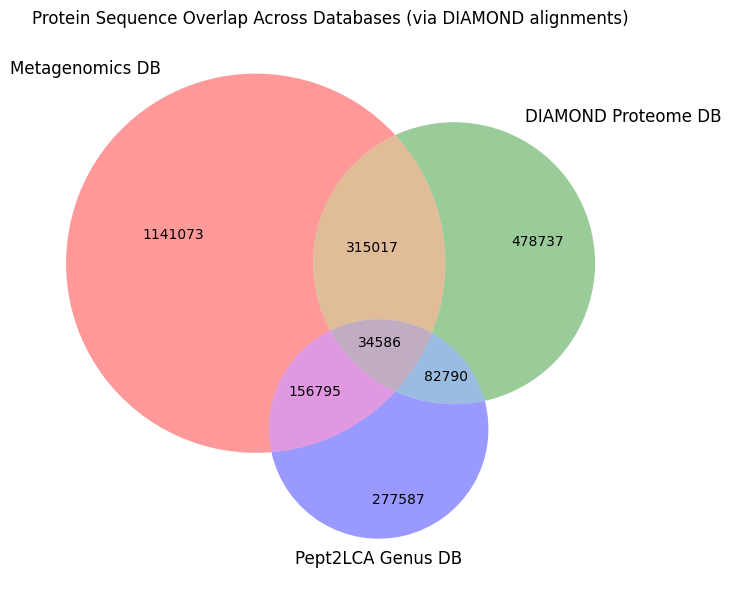

In [17]:
from pathlib import Path
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# === Correct file paths ===
fasta_diamond = Path(r"C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\pipelines\Diamond_alignments\session_diamond_align_2025-06-08_00-28-56\diamond_proteins_from_proteomes_clustered95_with_metadata.fasta")
fasta_genus = Path(r"C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\fasta_proteomes\session_2025-05-12_00-46-46\custom_database_genus.fasta")
fasta_metagen = Path(r"C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\db_psm_results\Metagenomics_db\GW_proteins_CD_clean.fasta")

align_dia_vs_meta = Path(r"C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\db_results_analysis\Diamond_alignments\Diamond_lca_proteomes_clustered95_aligned_with_metagenomicsdb.m8")
align_dia_vs_genus = Path(r"C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\db_results_analysis\Diamond_alignments\Diamond_lca_proteomes_clustered95_aligned_with_genusdb.m8")
align_genus_vs_meta = Path(r"C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\db_results_analysis\Diamond_alignments\genus_vs_metagenomics.m8")


# === Load protein sets from FASTA files ===
def count_fasta_headers(fasta_path):
    ids = set()
    with open(fasta_path) as f:
        for line in f:
            if line.startswith(">"):
                header = line[1:].strip().split()[0]
                if "|" in header:
                    parts = header.split("|")
                    if len(parts) > 1:
                        ids.add(parts[1])  # Use middle part (e.g. A0A...)
                    else:
                        ids.add(parts[0])  # fallback just in case
                else:
                    ids.add(header)
    return ids

diamond_prots = count_fasta_headers(diamond_fasta)
genus_prots = count_fasta_headers(genus_fasta)
metagen_prots = count_fasta_headers(metagen_fasta)

# === Load alignments as undirected hit pairs ===
def load_hit_pairs(path):
    df = pd.read_csv(path, sep="\t", header=None, usecols=[0, 1], dtype=str)
    pairs = set()
    for q, s in df.itertuples(index=False):
        def extract_id(val):
            return val.split("|")[1] if "|" in val and len(val.split("|")) > 1 else val.split()[0]
        q_id = extract_id(q)
        s_id = extract_id(s)
        pairs.add(tuple(sorted((q_id, s_id))))
    return pairs

# Load and flatten unique protein hits per DB
dia_meta_pairs = load_hit_pairs(align_dia_vs_meta)
dia_genus_pairs = load_hit_pairs(align_dia_vs_genus)
genus_meta_pairs = load_hit_pairs(align_genus_vs_meta)

# Extract unique proteins involved in alignments per database
dia_in_meta = {p for pair in dia_meta_pairs for p in pair if p in diamond_prots}
meta_in_dia = {p for pair in dia_meta_pairs for p in pair if p in metagen_prots}

dia_in_genus = {p for pair in dia_genus_pairs for p in pair if p in diamond_prots}
genus_in_dia = {p for pair in dia_genus_pairs for p in pair if p in genus_prots}

genus_in_meta = {p for pair in genus_meta_pairs for p in pair if p in genus_prots}
meta_in_genus = {p for pair in genus_meta_pairs for p in pair if p in metagen_prots}

# === Compute overlaps (allowing multiple alignments per protein but unique counts) ===
# Total proteins per DB
D = diamond_prots
G = genus_prots
M = metagen_prots

# Unique overlap sets
shared_all = dia_in_meta & dia_in_genus & genus_in_meta

D_and_M = dia_in_meta - shared_all
D_and_G = dia_in_genus - shared_all
G_and_M = genus_in_meta - shared_all

# === Correct exclusive counts by subtracting all overlaps from total ===
only_D = D - (D_and_M | D_and_G | shared_all)
only_G = G - (G_and_M | D_and_G | shared_all)
only_M = M - (D_and_M | G_and_M | shared_all)

# === Double-check overlap region sizes ===
only_D_count = len(D) - len(D_and_M) - len(D_and_G) - len(shared_all)
only_G_count = len(G) - len(G_and_M) - len(D_and_G) - len(shared_all)
only_M_count = len(M) - len(D_and_M) - len(G_and_M) - len(shared_all)

# === Print summary ===
print("--- Protein Sequence Overlap (based on DIAMOND alignments) ---")
print(f"Metagenomics DB:     {len(M):>8} proteins")
print(f"DIAMOND Proteome DB: {len(D):>8} proteins")
print(f"Pept2LCA Genus DB:   {len(G):>8} proteins")

# === Plot Venn ===
plt.figure(figsize=(8, 6))
venn3(
    subsets=(
        only_M_count,
        only_D_count,
        len(D_and_M),
        only_G_count,
        len(G_and_M),
        len(D_and_G),
        len(shared_all)
    ),
    set_labels=("Metagenomics DB", "DIAMOND Proteome DB", "Pept2LCA Genus DB")
)
plt.title("Protein Sequence Overlap Across Databases (via DIAMOND alignments)")
plt.tight_layout()
plt.show()


### Protein Sequence Overlap Between Databases (via DIAMOND alignments)

The Venn diagram above presents the protein-level overlap between three custom databases: the **Metagenomics DB**, the **DIAMOND Proteome DB**, and the **Pept2LCA Genus DB**. The analysis was performed using pairwise **DIAMOND `blastp` alignments**, treating each alignment as undirected and eliminating redundancy (i.e. one protein pair counted only once, even if bidirectional hits occurred). 

#### Total Protein Counts

- **Metagenomics DB**: 1,647,471 proteins  
- **DIAMOND Proteome DB**: 911,130 proteins  
- **Pept2LCA Genus DB**: 551,758 proteins  

#### Overlap Distribution

- **Shared by All Three Databases**: 34,586 proteins  
- **Shared by Metagenomics & DIAMOND Only**: 315,017 proteins  
- **Shared by Metagenomics & Genus Only**: 156,795 proteins  
- **Shared by DIAMOND & Genus Only**: 82,790 proteins  
- **Exclusive to Metagenomics**: 1,141,073 proteins  
- **Exclusive to DIAMOND**: 478,737 proteins  
- **Exclusive to Genus**: 277,587 proteins  

#### Biological Interpretation

The **Metagenomics DB** clearly captures the largest number of proteins, with over **1.14 million unique entries** not found in the reference-based or genus-informed databases. This indicates the high novelty and sample-specificity of environmental sequencing, reinforcing its essential role in metaproteomic studies targeting uncultivated microbial communities.

Meanwhile, the **DIAMOND DB** overlaps substantially with both the metagenomics and genus DBs, but still retains a sizeable exclusive core. This underlines the utility of reference proteomes in providing broad coverage, although their limitation in representing environment-specific diversity is evident.

The **Pept2LCA Genus DB**, though smaller in scale, contains unique protein sequences and overlaps notably with both other databases, showing that peptide-informed taxonomic filtering can retrieve relevant proteins missed by conventional approaches.

The small core of **shared proteins (n = 34,586)** among all three databases likely represents **well-conserved proteins** across public references, genus-filtered reconstructions, and de novo assembled metagenomes.

---

### Impact of Loose Alignment Parameters on Results

As shown in the alignment configuration screenshot, **default DIAMOND `--fast` mode was used**, and more stringent filters such as:

- `--evalue 1e-5` (statistical significance threshold),
- `--id 60` (minimum % identity), and
- `--query-cover 70` (minimum alignment length coverage)

were intentionally **commented out** to improve runtime.

#### Implications:

- **Higher Sensitivity**: Looser filters lead to a greater number of alignments, potentially capturing **more distant homologs** and weakly conserved matches.
- **Reduced Specificity**: Some detected overlaps may reflect **low-confidence or partial matches**, increasing the **risk of false positives** (e.g., aligning non-orthologous or domain-only regions).
- **Inflated Overlap Counts**: The **shared regions in the Venn diagram might be overestimated**, particularly for borderline matches that would be excluded with stricter cutoffs.

#### Recommendation:

While these results offer a comprehensive first-pass overview of sequence sharing, a **refined analysis with stricter thresholds** (e.g., `--evalue 1e-5`, `--id 60`, `--query-cover 70`) is advised to assess the robustness of detected overlaps. This will help distinguish **true homologous proteins** from spurious hits and offer a more conservative, biologically meaningful interpretation.

---

In conclusion, the presented overlap structure demonstrates the complementary nature of each database. Parameter tuning and post-alignment filtering will be essential for downstream tasks such as protein function annotation, peptide-spectrum matching (PSM), and taxonomic profiling.
